In [1]:
from sklearn import model_selection
from sklearn import metrics
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
import seaborn as sns

# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv',
 'MatrixDataCleanods.ods',
 'SampleMetaDataClean.csv',
 'SampleMetaDataClean_Org.csv',
 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.head()

,6,study,Study No. (From VG sheet (V-*) from SB sheet (S-*)),Title of Paper,Author (year),Journal,Study Accession,Sample Accession or Sample ID,Sample title (ENA/SRA),Sample title (Paper),...,Use of milk or milk products (Yes/No/Sometimes),Use of Animal Product- Meat (Yes/No/Vegetarian/Vegan),Alcohol Consumption (Yes/No),Diet1,Intervention for study (Diet),Intervention for study (medication),Sequencing Platform,Library layout (SINGLE/PAIRED),Read count after Quality control,Healthy
0,SAMEA104142287,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142287,ZSL-004,ZSL-004,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,43356775.0,Unhealthy
1,SAMEA104142288,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142288,ZSL-007,ZSL-007,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,41073871.0,Unhealthy
2,SAMEA104142293,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142293,ZSL-010,ZSL-010,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,40199673.0,Unhealthy
3,SAMEA104142291,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142291,ZSL-011,ZSL-011,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,31054158.0,Unhealthy
4,SAMEA104142284,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142284,ZSL-019,ZSL-019,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,36081150.0,Unhealthy


In [6]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


# Define and Train Model

In [8]:
# random seed here deals with model initialization
rfc = RandomForestClassifier( oob_score=True )
logit = LogisticRegression( solver="saga" )
clf = Pipeline( steps=[('rfc', SelectFromModel(rfc)), ('logistic', logit)] )
param_grid = {'rfc__estimator__n_estimators': [50, 100],
                'rfc__estimator__max_depth': [50, 100],
                'logistic__penalty':['elasticnet'],
                'logistic__l1_ratio': [0.01, 0.05, 0.1],
                'logistic__C':[100]}
model = model_selection.GridSearchCV(clf, param_grid, scoring = metrics.make_scorer(metrics.balanced_accuracy_score), cv = 5)
MyTrainer = Trainer(model = model, scale_X = True, use_pca = False)
# random seed used in class definition is not used in final output models
MyTrainTester = TrainTester(MyTrainer, metrics.balanced_accuracy_score)
# note that random seed here affects sequence of seeds passed to making new TrainTester objects
# using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
# across all data splits
n_splits = 5
MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)

In [9]:
y = SampleMeta['Phenotype'].to_numpy().astype('str')
#y = y.astype('int64')
y

array(['ACVD', 'ACVD', 'ACVD', ..., 'Underweight', 'Underweight',
       'Underweight'], dtype='<U27')

In [11]:
oneHotEncoders, oneHotMap = MyMultiTrainTester.buildEncoder( np.unique(y) )
oneHotMap

{'ACVD': 0,
 'CRC': 1,
 'Crohns disease': 2,
 'Healthy': 3,
 'IGT': 4,
 'Obesity': 5,
 'Overweight': 6,
 'Rheumatoid Arthritis': 7,
 'Symptomatic atherosclerosis': 8,
 'T2D': 9,
 'Ulcerative colitis': 10,
 'Underweight': 11,
 'advanced adenoma': 12}

In [12]:
y = np.array([ oneHotMap[class_pheno] for class_pheno in y ])
y

array([ 0,  0,  0, ..., 11, 11, 11])

In [13]:
MyMultiTrainTester.train(MatrixData, y)

Running for split 1 of 5
Running for split 2 of 5
Running for split 3 of 5
Running for split 4 of 5
Running for split 5 of 5


In [14]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.775578,train
1,0.773649,train
2,0.748133,train
3,0.789894,train
4,0.757375,train
0,0.291522,test
1,0.269194,test
2,0.361738,test
3,0.288406,test
4,0.376403,test


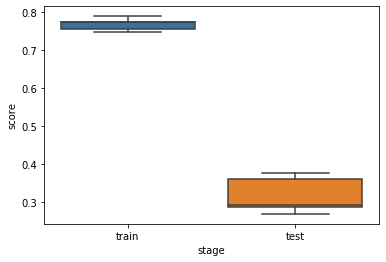

In [15]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

In [16]:
FinalModel = MyMultiTrainTester.TrainerList[0]

In [17]:
FinalModel.model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rfc',
                                        SelectFromModel(estimator=RandomForestClassifier(oob_score=True))),
                                       ('logistic',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'logistic__C': [100],
                         'logistic__l1_ratio': [0.01, 0.05, 0.1],
                         'logistic__penalty': ['elasticnet'],
                         'rfc__estimator__max_depth': [50, 100],
                         'rfc__estimator__n_estimators': [50, 100]},
             scoring=make_scorer(balanced_accuracy_score))

In [18]:
FinalModel.model.best_estimator_

Pipeline(steps=[('rfc',
                 SelectFromModel(estimator=RandomForestClassifier(max_depth=50,
                                                                  oob_score=True))),
                ('logistic',
                 LogisticRegression(C=100, l1_ratio=0.1, penalty='elasticnet',
                                    solver='saga'))])

In [19]:
feat_importances = pd.DataFrame(FinalModel.model.best_estimator_.steps[0][1].estimator_.feature_importances_, index=FeatMeta.feature, columns=["Importance"])
feat_importances.sort_values(["Importance"], ascending=False, inplace=True)

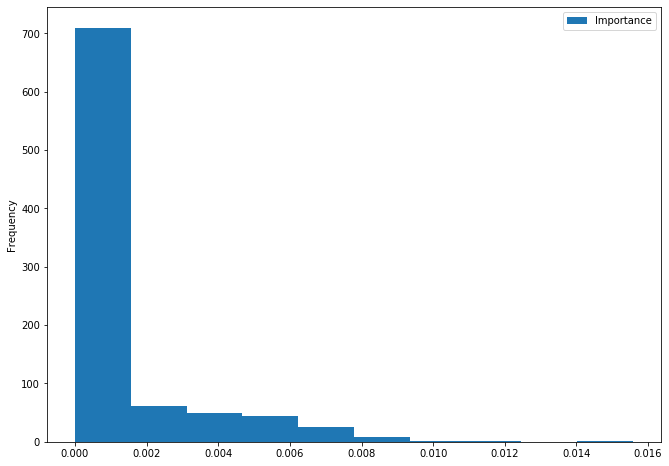

In [20]:
feat_importances.plot(kind="hist", figsize=(11, 8))

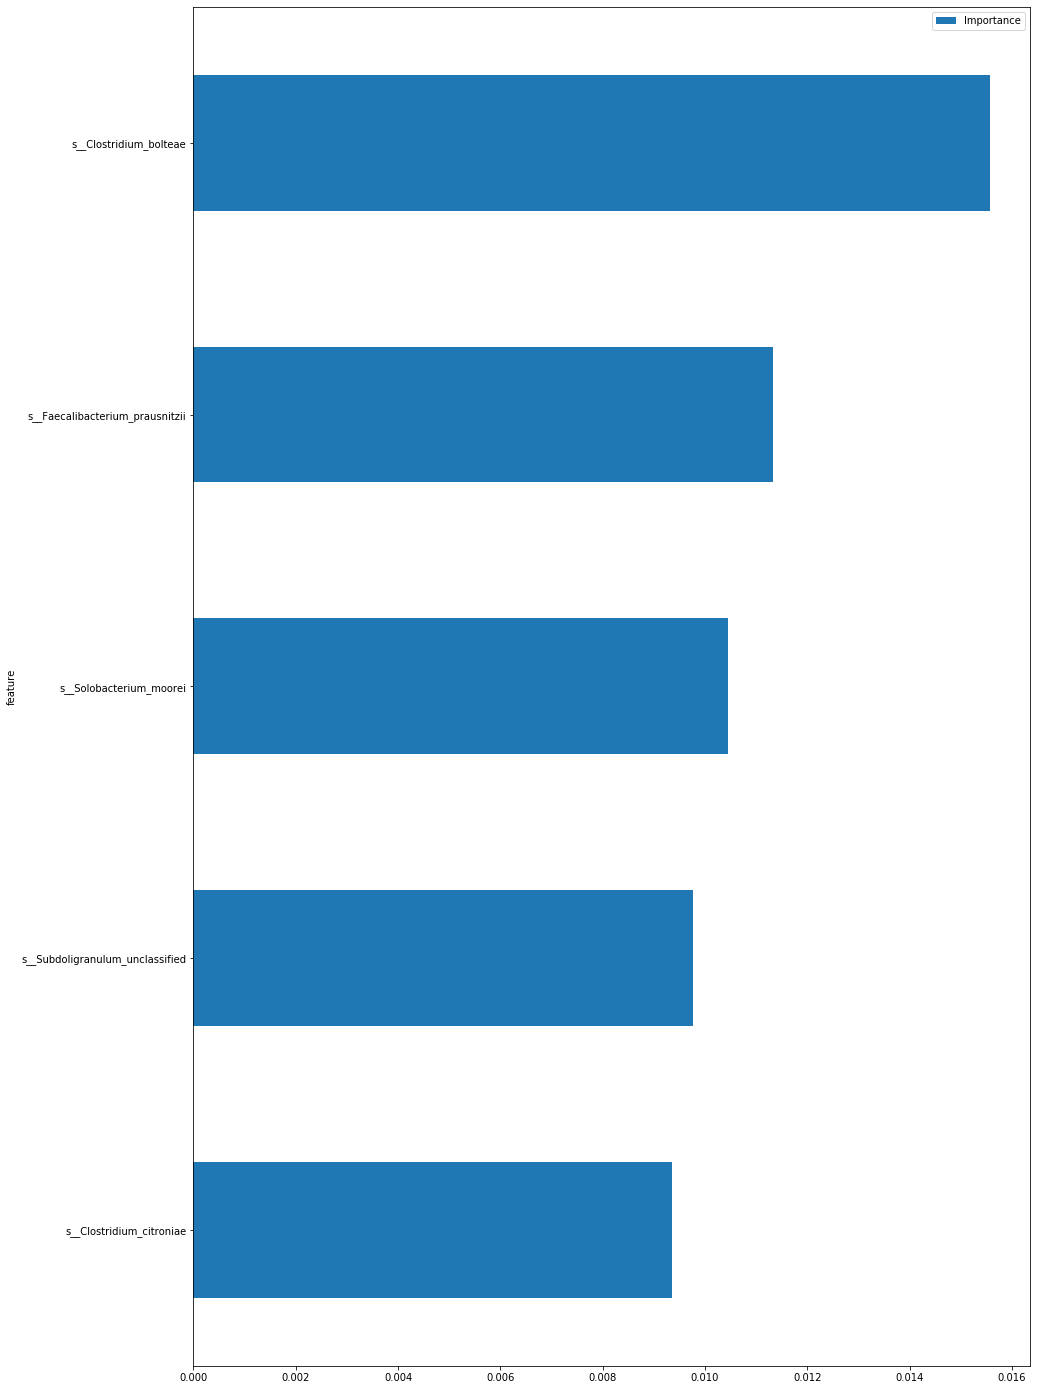

In [21]:
feat_importances = feat_importances[feat_importances>0.009].dropna()
feat_importances.sort_values(["Importance"], ascending=True).plot(kind='barh', figsize=(15,25))

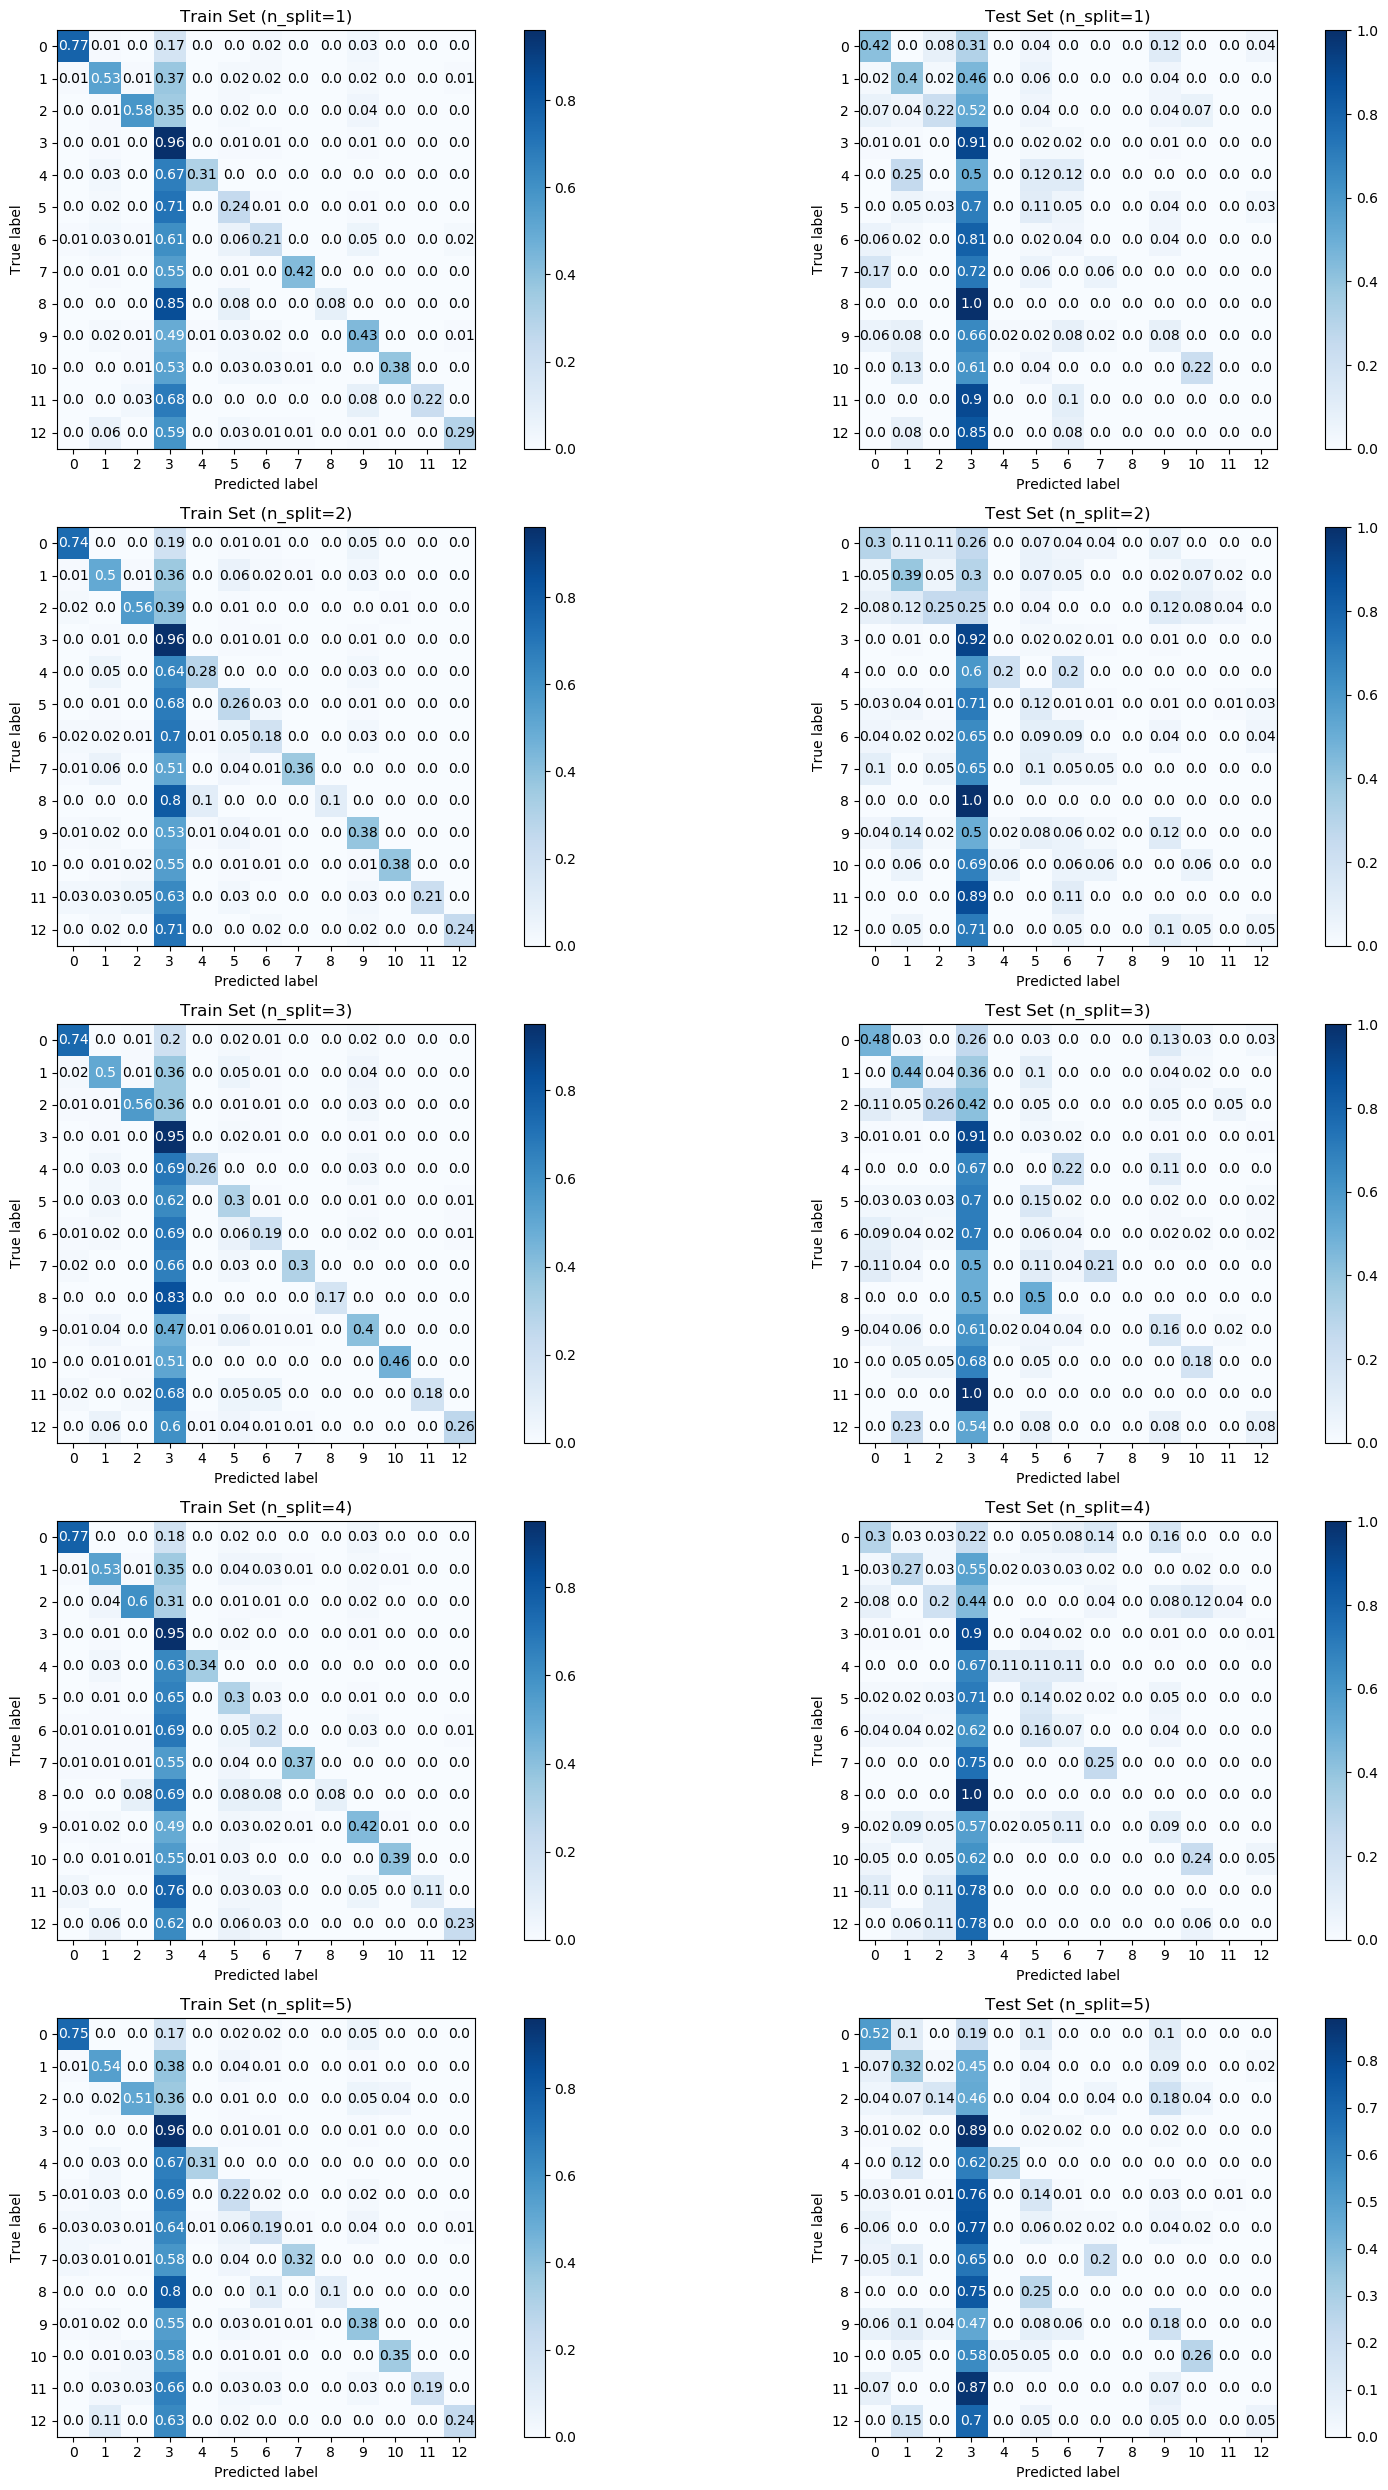

In [22]:
MyMultiTrainTester.plot_confusion(normalize=True)

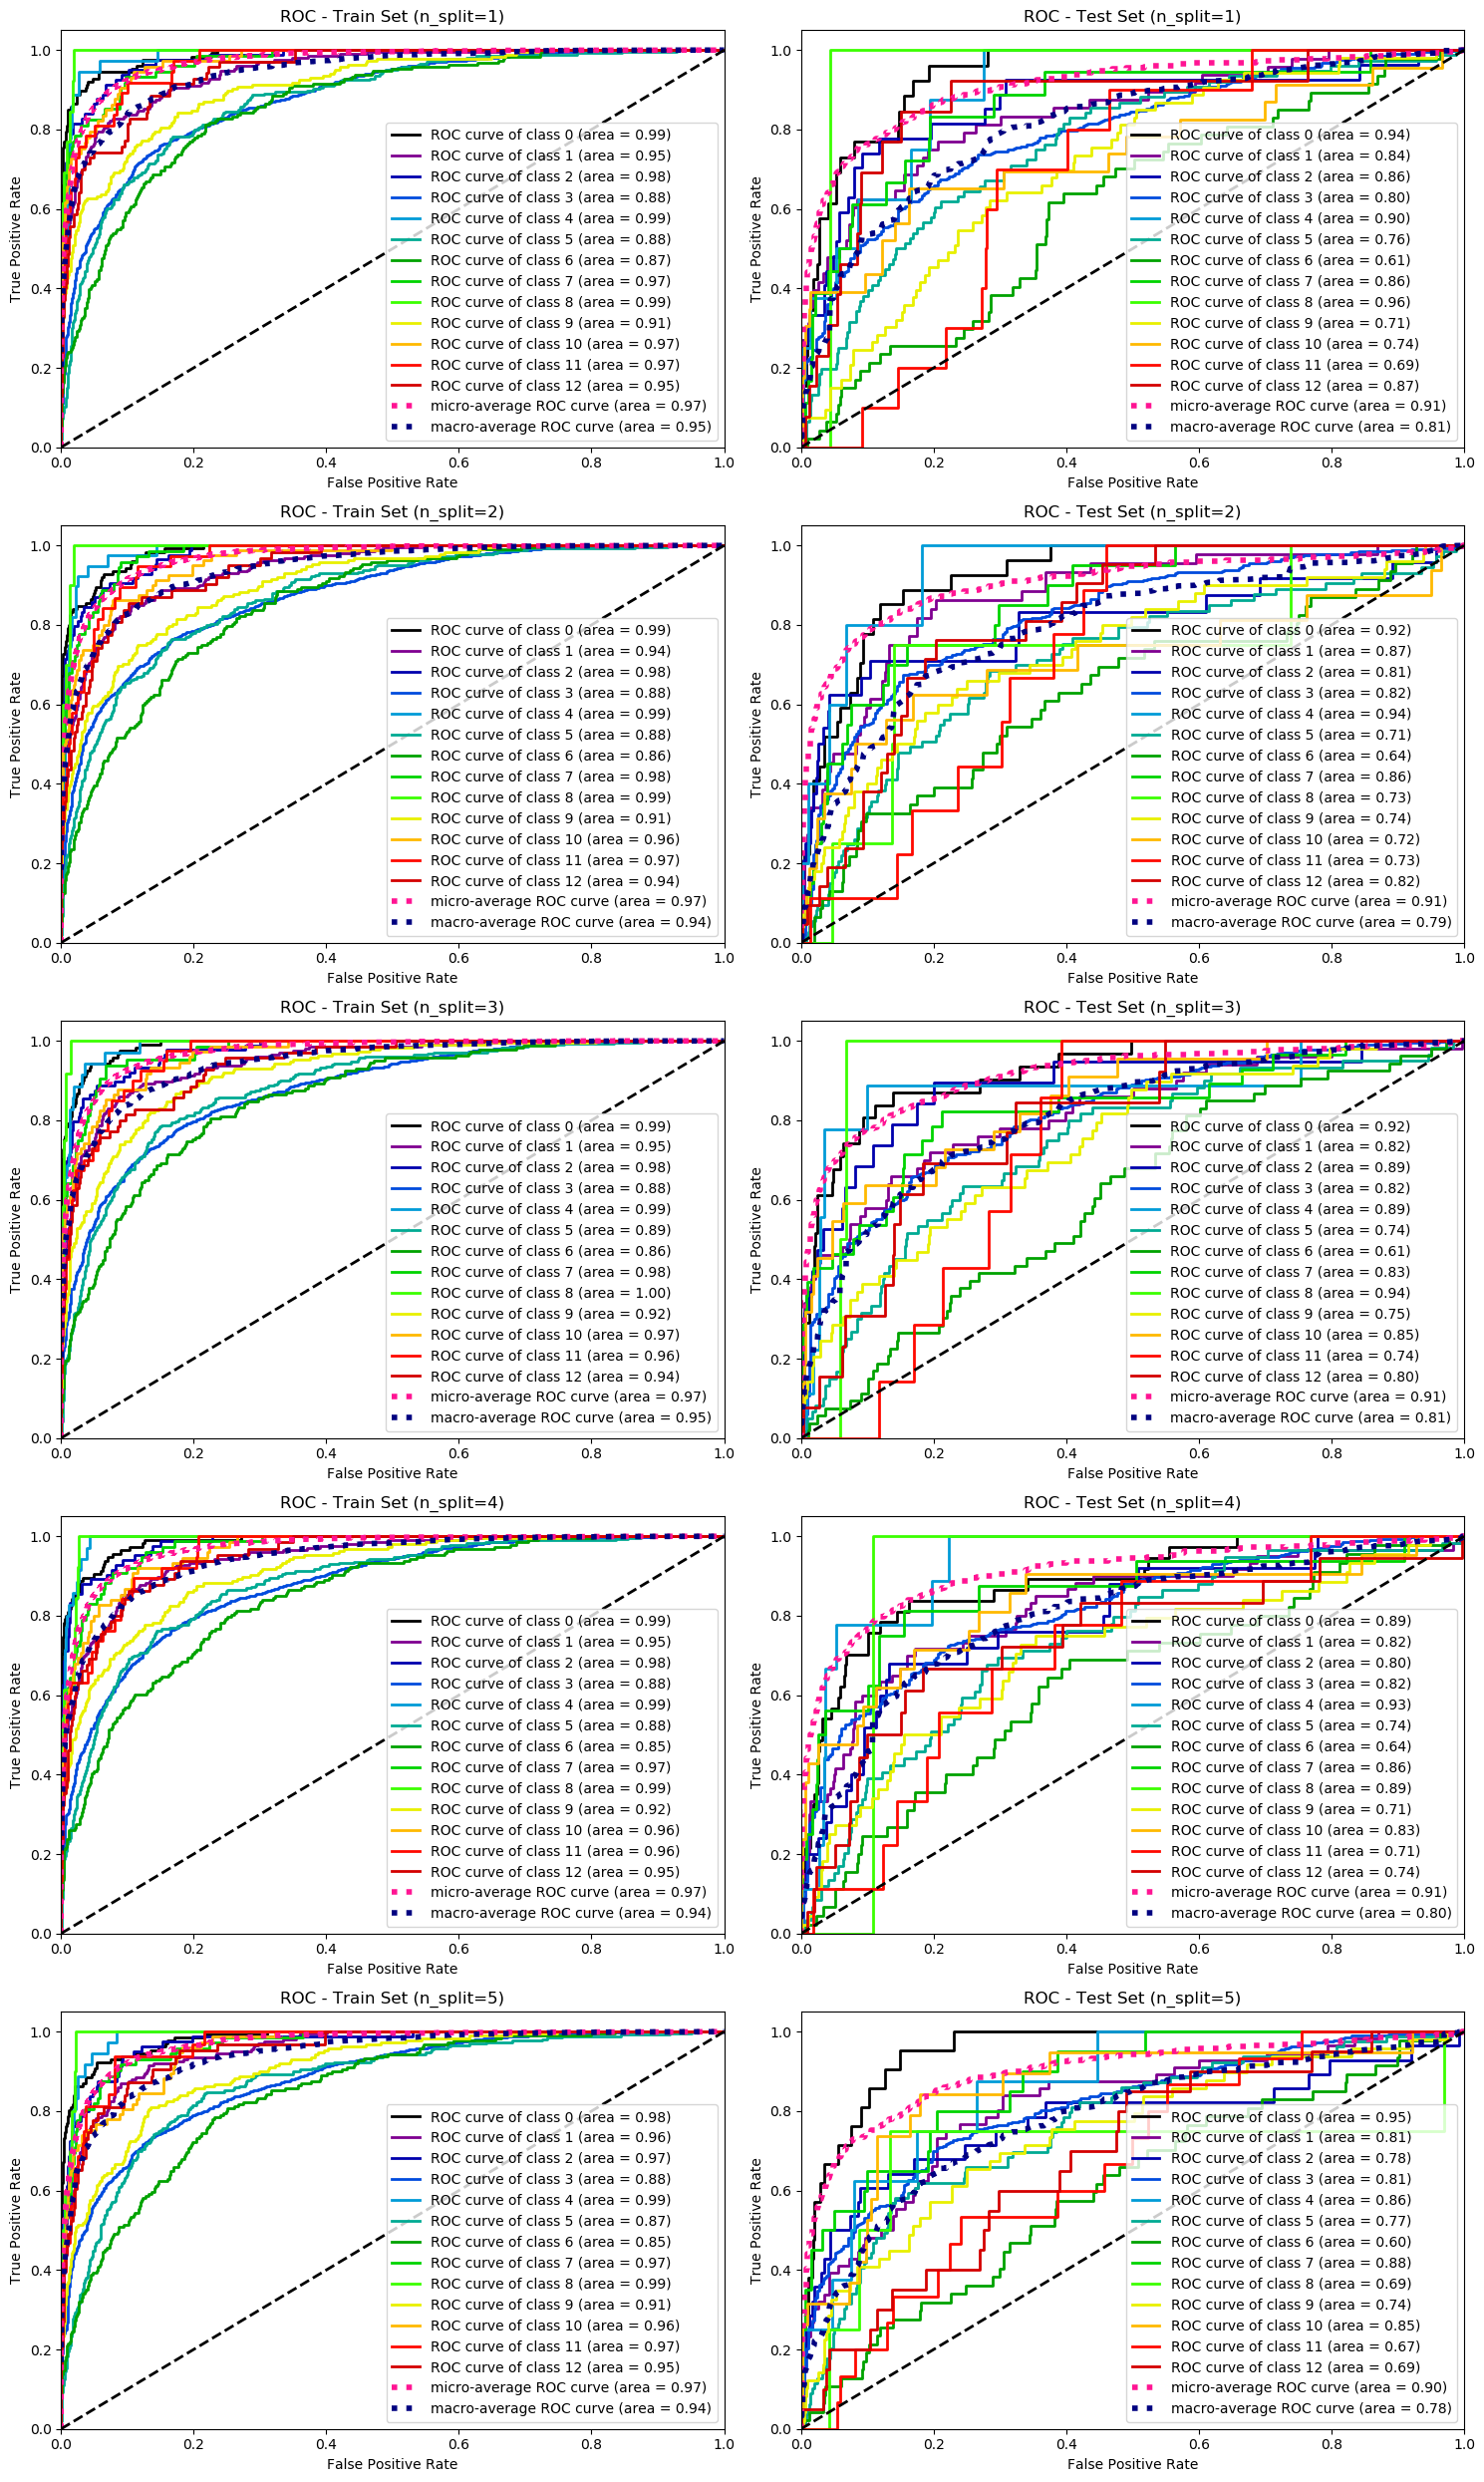

In [23]:
MyMultiTrainTester.plot_roc()